In [1]:
import coffea
import coffea.hist as hist
import uproot
import matplotlib.pyplot as plt
import mplhep as hep
import numpy as np

import awkward as ak

from sklearn.cluster import DBSCAN

from coffea.nanoevents import NanoEventsFactory, NanoAODSchema,BaseSchema

/cvmfs/sft.cern.ch/lcg/views/LCG_105/x86_64-el9-gcc11-opt/lib/python3.9/site-packages/coffea/util.py:154: FutureWarning: In coffea version v2023.3.0 (target date: 31 Mar 2023), this will be an error.
(Set coffea.deprecations_as_errors = True to get a stack trace now.)
ImportError: coffea.hist is deprecated
  warnings.warn(message, FutureWarning)


In [2]:
from collections import OrderedDict

# Load ntuples
Here we will load ntuples for signal and data (high-MET skim), where the clusters are already reconstructed and stored in the ntuples. We will use these ntuples to plot some of the key variables that will used to veto background clusters

In [3]:
fpath={}
tree ={}


# load high-MET skim data
path = '/eos/uscms/store/user/cmsdas/2026/long_exercises/MDS/data/'
fpath['data'] = path + 'Run2_displacedJetMuonNtupler_V1p17_Data2016_Data2017_Data2018-HighMET_goodLumi.root'

mass = [40]
OLD_CTAU = np.array([1000, 10000, 100000])#in mm

path = '/eos/uscms/store/user/cmsdas/2025/long_exercises/MDS/signal/nocuts/'

for m in mass:
    for ct in OLD_CTAU:
        key = 'MC_'+str(m)+'_'+str(ct)                       
        fpath[key] = path +  'ggH_HToSSTobbbb_MH-125_MS-40_ctau-'+str(ct)+'_137000pb_weighted.root'
        
        
for k,v in fpath.items():
    tree[k] = NanoEventsFactory.from_root(v,
                                   schemaclass=BaseSchema,
                                   treepath="MuonSystem"
                                  ).events()

# Trigger selection

Trigger selection is the beginning of any CMS analysis. 

We are using `MET > 200 GeV` due to the lack of dedicated trigger on the MDS object. 

As a result, in order for signal events to pass the large MET trigger 
 - the Higgs is recoiled against a high pT jet
 - the large pT of Higgs creates the MET as it decays
 - the trigger efficiency is low
 
You will try to confirm this for yourself first.

 - Use the `met` branch to access the reconstructed MET
 - Use the `gHiggsPt` branch to access the generated Higgs pT for  

# Ex: Trigger efficiency for signals

In [4]:
plt.style.use(hep.style.CMS)  

(exptext: Custom Text(0.0, 1, 'CMS'),
 expsuffix: Custom Text(0.0, 1.005, 'Simulation Preliminary'))

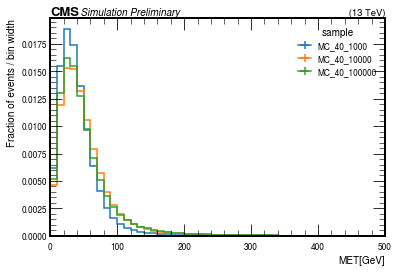

In [5]:
h_MET= hist.Hist("Events",
              hist.Cat("sample","sample"), 
              hist.Bin("met", "MET[GeV]", 50, 0, 500)
             )

for m in mass:
    for ct in OLD_CTAU:
        # Fill in the code
        sample = 'MC_'+str(m)+'_'+str(ct) 
        h_MET.fill(sample = sample, met = tree[sample].met )
        
ax = hist.plot1d(h_MET,density=True)
ax.set_ylabel("Fraction of events / bin width")
hep.cms.label(ax=ax,label="Preliminary") 

# Q: What is the signal efficiencies for MET>200 GeV?

 - Use the following function to integral the dense axes from `thres_lo` to infinity

In [6]:
#  Integral the dense axes from thres_lo to infinity
def integral(h,sample,thres_lo):
    
    dense_axis = h.dense_axes()[0]
    name = h.dense_axes()[0].name
    
    numer = h.integrate("sample",sample).integrate(name,slice(thres_lo,None),overflow="over").values()[()]
    denom = h.integrate("sample",sample).sum(name,overflow="over").values()[()]    
    
    return numer/denom

#  Integral the dense axes from 0 to thres_high
def integral_low(h,sample,thres_high):
    
    name = h.dense_axes()[0].name

    numer = h.integrate("sample",sample).integrate(name,slice(None,thres_high)).values()[()]
    denom = h.integrate("sample",sample).sum(name,overflow="over").values()[()]    

    return numer/denom

In [9]:
h_MET.dense_axes()[0].edges()[0]

0.0

In [10]:
# Choose from the following bin edges
h_MET.axis("met").edges()

array([  0.,  10.,  20.,  30.,  40.,  50.,  60.,  70.,  80.,  90., 100.,
       110., 120., 130., 140., 150., 160., 170., 180., 190., 200., 210.,
       220., 230., 240., 250., 260., 270., 280., 290., 300., 310., 320.,
       330., 340., 350., 360., 370., 380., 390., 400., 410., 420., 430.,
       440., 450., 460., 470., 480., 490., 500.])

In [11]:
for m in mass:
    for ct in OLD_CTAU:
        sample = 'MC_'+str(m)+'_'+str(ct) 
        # Fill the code
        eff = integral(h_MET,sample,200)/integral(h_MET,sample,0)
        print("sample = %s, eff(MET>200) = %.5f "%(sample, eff))

sample = MC_40_1000, eff(MET>200) = 0.00590 
sample = MC_40_10000, eff(MET>200) = 0.01318 
sample = MC_40_100000, eff(MET>200) = 0.01484 


# Ex: Plot the MET and Higgs pT for signals

 - Focus on the region beyond 200 GeV
 - Q: What do you observe?

(exptext: Custom Text(0.0, 1, 'CMS'),
 expsuffix: Custom Text(0.0, 1.005, 'Simulation Preliminary'))

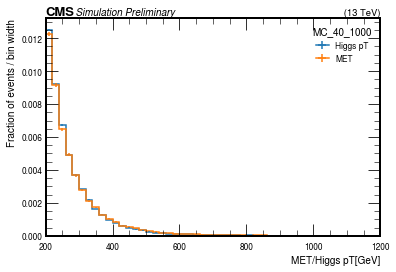

In [12]:
h= hist.Hist("Events",
              hist.Cat("var","Variable"), 
              hist.Bin("pT", "MET/Higgs pT[GeV]", 50, 200, 1200)
             )

sample = "MC_40_1000"
# Fill the code
h.fill(var = "MET", pT = tree[sample].met )
h.fill(var = "Higgs pT", pT = tree[sample].gHiggsPt )
        
ax = hist.plot1d(h,density=True)
ax.legend(title = sample)
ax.set_ylabel("Fraction of events / bin width")
hep.cms.label(ax=ax,label="Preliminary") 

# Event selections

The event selections for this search are kept at minimal to be as model independent as possible. 

The full event-level selections are 
 - MET trigger 
 - offline MET > 200 GeV
 - MET filters (make sure MET is not badly reconstructed)

For the ISR jet, the selections are
 - pT > 30 GeV
 - abs($\eta$) < 2.4
 - Pass tight jet Id

In [13]:
def select_events(events,isData=False):
    
    ########### SELECTION: CLUSTERS ############
    ### At least 1 cluster (decay in CSC and matched to LLP for signal)
    ###
    if isData:
        sel_clusters = (events.cscRechitClusterSize)>0
    else:
        sel_clusters = (events.cscRechitCluster_match_gLLP==True) & (events.cscRechitCluster_match_gLLP_csc==True)

    ########### SELECTION: JETS ############
    sel_jet = (events.jetPt > 30) &\
              (abs(events.jetEta)<2.4) &\
              (events.jetTightPassId==True)
    
    ########### SELECTION: events ############
    # at least 1 selected cluster and jets
    sel_ev =  (events.METTrigger==True) &\
              (events.met>200) &\
              (events.metFilters==True) &\
              (ak.sum(sel_jet,axis=1)>=1) &\
              (ak.sum(sel_clusters,axis=1)>0)   
    
    return sel_clusters, sel_jet, sel_ev

In [14]:
events = tree['data']

In [17]:
sel_clusters, sel_jet, sel_ev = select_events(events)

# Cluster level selections

Aside from the MDS shower, there are not many handles in the events to reject background events.

Afterall, we only expect the shower, MET and an ISR jet in the signal events. 

Therefore, we will focus on using the MDS object features to enhance the signal to background ratio.  

First, we need to remove objects from the SM that could also create showers in the muon system. 

 - Punch-through jets
 - high pT muons


The dominant background from the main collision comes from punch-through jets that are not fully contained in the calorimeters and high pT muons that could create bremsstrahlung showers in the muon detectors. 

To remove those background, we reject clusters by matching them to reconstructed jets and muon. 

The pT of the jet/muon that the cluster is matched to are saved in objects called `cscRechitClusterJetVetoPt` 
and `cscRechitClusterMuonVetoPt`. 

In this exercise you will plot the two variables for signal and background and apply a selection on the two variables to remove clusters from jets and muons.

# Ex1 - plot jet veto and muon veto

 - Access the jet veto pT with `cscRechitClusterJetVetoPt`
 - Access the muon veto pT with `cscRechitClusterMuonVeto`

In [18]:
nBins    = 50
bin_lo   = 0 
bin_high = 500 

h = hist.Hist("Events",
              hist.Cat("sample","sample"), 
              hist.Bin("pt", "Jet veto pT[GeV]", nBins, bin_lo, bin_high)
             )

for i, sample in enumerate(tree.keys()):
    
    #See if we are treating data
    isData = True if ("data" in sample) else False
    
    # build the selection arrays
    sel_clusters, sel_jet, sel_ev = select_events(tree[sample],isData)

    # get the Jet veto Pt
    VetoPt = tree[sample].cscRechitClusterJetVetoPt
    
    # Event and cluster selections (make sure we have a cluster [and matched to LLP in CSC] )
    VetoPt = VetoPt[(sel_clusters) &(sel_ev)]
    
    # Select the VetoPt of the largest cluster 
    # fill_none puts -1 for events without clusters that satisfy the cluster cuts
    VetoPt = ak.fill_none(ak.firsts(VetoPt,axis=1),-1 ) 
    
    h.fill(sample=sample,pt=VetoPt)

(exptext: Custom Text(0.001, 1, 'CMS'),
 expsuffix: Custom Text(0.001, 1.005, 'Simulation Preliminary'))

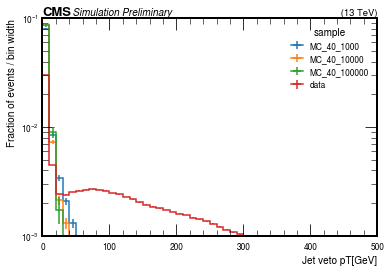

In [19]:
ax = hist.plot1d(h,density=True)
ax.set_ylabel("Fraction of events / bin width")
ax.set_yscale("log")
ax.set_ylim(1e-3,0.1)
hep.cms.label(ax=ax,label="Preliminary") 

# Q: What are the efficiencies Jet veto pT < 10 GeV?

In [20]:
# Hint: use integral_low and integral

for i, sample in enumerate(tree.keys()):
    # Fill code here
    eff = integral_low(h,sample,10)/integral(h,sample,0)
    print("sample = %s, eff(VetoPT<10) = %.5f "%(sample, eff))

sample = data, eff(VetoPT<10) = 0.28715 
sample = MC_40_1000, eff(VetoPT<10) = 0.80030 
sample = MC_40_10000, eff(VetoPT<10) = 0.86611 
sample = MC_40_100000, eff(VetoPT<10) = 0.86957 


# Plot muon veto 

In [21]:
nBins    = 50
bin_lo   = 0 
bin_high = 500 

h = hist.Hist("Events",
              hist.Cat("sample","sample"), 
              hist.Bin("pt", "Muon veto pT[GeV]", nBins, bin_lo, bin_high)
             )


for i, sample in enumerate(tree.keys()):
    
    #See if we are treating data
    isData = True if ("data" in sample) else False
    
    # build the selection arrays
    sel_clusters, sel_jet, sel_ev = select_events(tree[sample],isData)

    # get the Muon veto Pt
    VetoPt = tree[sample].cscRechitClusterMuonVetoPt
    
    # Event and cluster selections (make sure we have a cluster [and matched to LLP in CSC] )
    VetoPt = VetoPt[(sel_clusters) & (sel_ev)]
    
    # Select the VetoPt of the largest cluster 
    # fill_none puts -1 for events without clusters that satisfy the cluster cuts
    VetoPt = ak.fill_none(ak.firsts(VetoPt,axis=1),-1 ) 
    
    h.fill(sample=sample,pt=VetoPt)

(exptext: Custom Text(0.001, 1, 'CMS'),
 expsuffix: Custom Text(0.001, 1.005, 'Simulation Preliminary'))

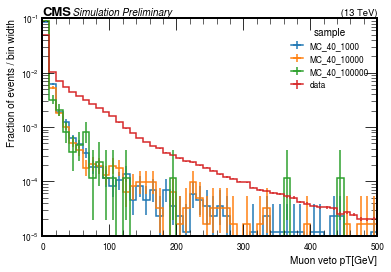

In [22]:
ax = hist.plot1d(h,density=True)
ax.set_ylabel("Fraction of events / bin width")
ax.set_yscale("log")
ax.set_ylim(1e-5,0.1)
hep.cms.label(ax=ax,label="Preliminary") 

# Q: What are the efficiencies Muon veto pT < 20 GeV?

In [23]:
# Hint: use integral_low and integral

for i, sample in enumerate(tree.keys()):
    # Fill code here
    eff = integral_low(h,sample,20)/integral(h,sample,0)
    print("sample = %s, eff(Muon VetoPT < 20) = %.5f "%(sample, eff))

sample = data, eff(Muon VetoPT < 20) = 0.59212 
sample = MC_40_1000, eff(Muon VetoPT < 20) = 0.93347 
sample = MC_40_10000, eff(Muon VetoPT < 20) = 0.93918 
sample = MC_40_100000, eff(Muon VetoPT < 20) = 0.94279 


# Ex2 - plot number of ME11 and ME12 hits in the cluster

Additionally, punch-through jets or muon bremsstrahlung showers *might not get reconstructed as jets and muons*.

To fully remove these background, we remove clusters that have hits in the first CSC stations (ME11/ME12) that have little shielding in front.

In this exercise, you will plot the number of ME11/ME12 hits in clusters for signal and background and apply a selection on the two variables to remove clusters from jets and muons.

## plot number of ME11 and ME12 hits in cluster

 - Access the number of chamber hits in the cluster with the following variables:
   - `cscRechitClusterNRechitChamberPlus11`
   - `cscRechitClusterNRechitChamberMinus11`
   - `cscRechitClusterNRechitChamberPlus12`
   - `cscRechitClusterNRechitChamberMinus12`

In [24]:
nBins    = 50
bin_lo   = 0 
bin_high = 50

h = hist.Hist("Events",
              hist.Cat("sample","sample"), 
              hist.Bin("nME11_12", r"$N_{Me11/12 hits}$", nBins, bin_lo, bin_high)
             )


for i, sample in enumerate(tree.keys()):
    
    #See if we are treating data
    isData = True if ("data" in sample) else False
    
    # build the selection arrays
    sel_clusters, sel_jet, sel_ev = select_events(tree[sample],isData)

    # Compute nME11_12
    nME11_12 = tree[sample].cscRechitClusterNRechitChamberPlus11+\
            tree[sample].cscRechitClusterNRechitChamberMinus11+\
            tree[sample].cscRechitClusterNRechitChamberPlus12+\
            tree[sample].cscRechitClusterNRechitChamberMinus12
    
    # Event and cluster selections (make sure we have a cluster [and matched to LLP in CSC] )
    nME11_12 = nME11_12[(sel_clusters) & (sel_ev)]
    
    # Select the VetoPt of the largest cluster 
    # fill_none puts -1 for events without clusters that satisfy the cluster cuts
    nME11_12 = ak.fill_none(ak.firsts(nME11_12,axis=1),-1 ) 
    
    h.fill(sample=sample,nME11_12=nME11_12)

(exptext: Custom Text(0.001, 1, 'CMS'),
 expsuffix: Custom Text(0.001, 1.005, 'Simulation Preliminary'))

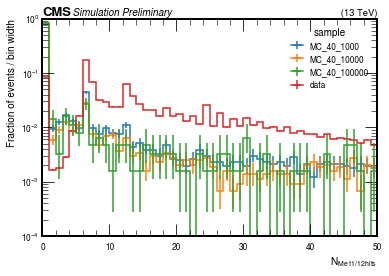

In [25]:
ax = hist.plot1d(h,density=True)
ax.set_ylabel("Fraction of events / bin width")
ax.set_yscale("log")
ax.set_ylim(1e-4,1)
hep.cms.label(ax=ax,label="Preliminary") 

# Q: What are the efficiencies for nME11_12 ==0?

In [266]:
# Hint: use integral_low and integral

for i, sample in enumerate(tree.keys()):
    # Fill code here
    eff = integral_low(h,sample,1)/integral(h,sample,0)
    print("sample = %s, eff(nME11_12 ==0) = %.5f "%(sample, eff))

sample = data, eff(nME11_12 ==0) = 0.03034 
sample = MC_40_1000, eff(nME11_12 ==0) = 0.48864 
sample = MC_40_10000, eff(nME11_12 ==0) = 0.58106 
sample = MC_40_100000, eff(nME11_12 ==0) = 0.59497 


# Ex3 - plot cluster eta

After we removed punch-through jets and muon brems, we observed that there are a lot more backgorund in higer $\eta$ region, where the muon reconstruction efficiency is lower and more pileup particles are present to create clusters.

In this exercise you will plot the cluster $\eta$ for signal and background and apply a selection on the variable to remove clusters from high $\eta$ region.

In [278]:
nBins    = 50
bin_lo   = 0.5 
bin_high = 3

h = hist.Hist("Events",
              hist.Cat("sample","sample"), 
              hist.Bin("eta", r"cluster $\eta$", nBins, bin_lo, bin_high)
             )


for i, sample in enumerate(tree.keys()):
    
    #See if we are treating data
    isData = True if ("data" in sample) else False
    
    # build the selection arrays
    sel_clusters, sel_jet, sel_ev = select_events(tree[sample],isData)

    # Get cluster Eta
    clsEta = tree[sample].cscRechitClusterEta
    
    # Event and cluster selections (make sure we have a cluster [and matched to LLP in CSC] )
    clsEta = clsEta[(sel_clusters) & (sel_ev)]
    
    # Select the VetoPt of the largest cluster 
    # fill_none puts -1 for events without clusters that satisfy the cluster cuts
    clsEta = ak.fill_none(ak.firsts(clsEta,axis=1),-1 ) 
    
    h.fill(sample=sample,eta=clsEta)

(exptext: Custom Text(0.001, 1, 'CMS'),
 expsuffix: Custom Text(0.001, 1.005, 'Simulation Preliminary'))

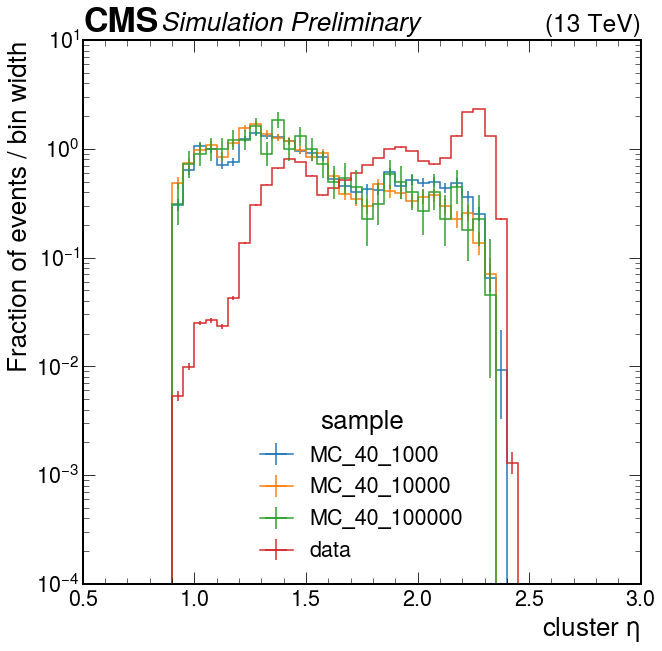

In [279]:
ax = hist.plot1d(h,density=True)
ax.set_ylabel("Fraction of events / bin width")
ax.set_yscale("log")
ax.set_ylim(1e-4,10)
hep.cms.label(ax=ax,label="Preliminary") 

# Q: What are the efficiencies for $abs(\eta)<2$ ?

In [282]:
# Hint: use integral_low and integral

for i, sample in enumerate(tree.keys()):
    # Fill code here
    eff = integral_low(h,sample,2.0)/integral(h,sample,0.5)
    print(r'sample = %s, eff(abs($\eta$)<2 ==0) = %.5f '%(sample, eff))

sample = data, eff(abs($\eta$)<2 ==0) = 0.51481 
sample = MC_40_1000, eff(abs($\eta$)<2 ==0) = 0.86975 
sample = MC_40_10000, eff(abs($\eta$)<2 ==0) = 0.91370 
sample = MC_40_100000, eff(abs($\eta$)<2 ==0) = 0.91011 


# Ex4 - plot cluster time (after vetos are applied)

The remaining background clusters after punch-through jet and muon brem showers from the main collision are removed, are from low pT particles in pileup events.

To verify this, you will plot the cluster time for signal and background, after applying the vetoes, in this exercise to check for any out-of-time pileup contributions in data.


In [286]:
nBins    = 50
bin_lo   = -100 
bin_high = 100

h = hist.Hist("Events",
              hist.Cat("sample","sample"), 
              hist.Bin("time", r"cluster time[ns]", nBins, bin_lo, bin_high)
             )


for i, sample in enumerate(tree.keys()):
    
    #See if we are treating data
    isData = True if ("data" in sample) else False
    
    # build the selection arrays
    sel_clusters, sel_jet, sel_ev = select_events(tree[sample],isData)

    # Get Variables
    clsTime  = tree[sample].cscRechitClusterTime
    jetVeto  = tree[sample].cscRechitClusterJetVetoPt
    muonVeto = tree[sample].cscRechitClusterMuonVetoPt 
    clsEta   = tree[sample].cscRechitClusterEta    
    
    # Apply cluster selection
    clsTime = clsTime[(sel_clusters) & (jetVeto<10) & (muonVeto<20) & (clsEta<2)& (sel_ev)]
    
    # Select the VetoPt of the largest cluster 
    # fill_none puts -1 for events without clusters that satisfy the cluster cuts
    clsTime = ak.fill_none(ak.firsts(clsTime,axis=1),-999 ) 
    
    h.fill(sample=sample,time=clsTime)

(exptext: Custom Text(0.0, 1, 'CMS'),
 expsuffix: Custom Text(0.0, 1.005, 'Simulation Preliminary'))

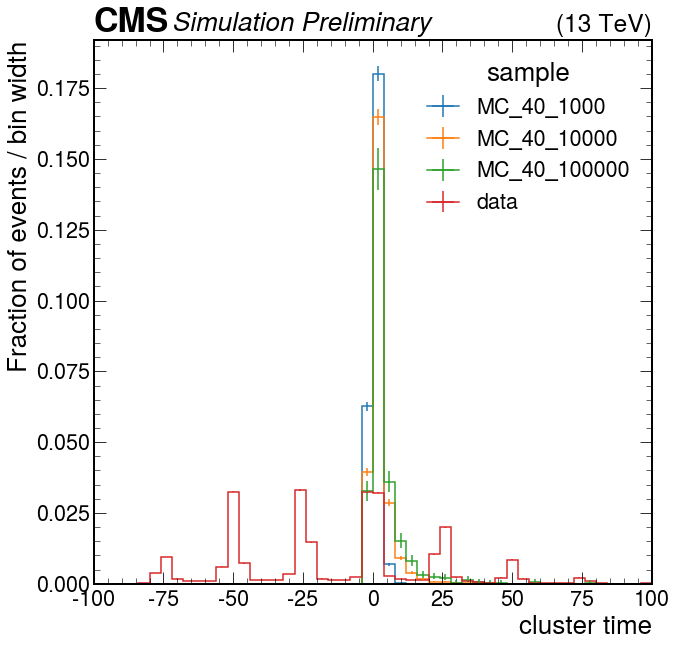

In [292]:
ax = hist.plot1d(h,density=True)
ax.set_ylabel("Fraction of events / bin width")
hep.cms.label(ax=ax,label="Preliminary") 

# Q: What are the efficiencies for $-5<t<12.5$ ns ?

In [291]:
def integral_range(h,sample,thres_lo,thres_high):
    
    name = h.dense_axes()[0].name

    numer = h.integrate("sample",sample).integrate(name,slice(thres_lo,thres_high)).values()[()]
    denom = h.integrate("sample",sample).sum(name,overflow="over").values()[()]    

    return numer/denom

for i, sample in enumerate(tree.keys()):
    # Fill code here
    eff = integral_range(h,sample,-5,12.5)/integral(h,sample,None)
    print(r'sample = %s, eff( -5<t<12.5 ==0) = %.5f '%(sample, eff))

sample = data, eff( -5<t<12.5 ==0) = 0.27493 
sample = MC_40_1000, eff( -5<t<12.5 ==0) = 0.99968 
sample = MC_40_10000, eff( -5<t<12.5 ==0) = 0.96748 
sample = MC_40_100000, eff( -5<t<12.5 ==0) = 0.91801 


# Q: Can you suggest an out-of-time validation region based on the above plot?

A good validation region needs to have:
 - No (or at least small) signal conteminations (i.e. signal depleted) 
 - Similar background composition as your signal-rich region

# Ex5 - plot $\Delta\phi\mathrm{(cluster, MET)}$ and $N_{hits}$ in Out-of-time Validation Region (final discriminating variables)


The final discriminating variables that we will use to extract the signal and estimate background are 
 - the number of hits in the cluster ($N_{\text{hits}}$) and
 - the azimuthal angle between the cluster and MET ( $\Delta\phi\text{(cluster, MET)}$).

The background estimation method will be described in more detail in the next episode.

In this exercise, we will just plot the distributions of the two variables, to understand the shape of the two variables.

## Plot data only in OOT region to avoid unblinding!

## plot $N_{hits}$

In [309]:
nBins    = 50
bin_lo   = 50
bin_high = 1000

h = hist.Hist("Events",
              hist.Cat("sample","sample"), 
              hist.Bin("nhits", r"$N_{hits}$", nBins, bin_lo, bin_high)
             )


for i, sample in enumerate(tree.keys()):
    
    #See if we are treating data
    isData = True if ("data" in sample) else False
    
    # build the selection arrays
    sel_clusters, sel_jet, sel_ev = select_events(tree[sample],isData)

    # Get Variables
    nhits    = tree[sample].cscRechitClusterSize
    clsTime  = tree[sample].cscRechitClusterTime
    jetVeto  = tree[sample].cscRechitClusterJetVetoPt
    muonVeto = tree[sample].cscRechitClusterMuonVetoPt 
    clsEta   = tree[sample].cscRechitClusterEta    

    
    # Only plot Out-of-Time(OOT) region
    if isData:
        sel_time = clsTime< -12.5
    else:
        sel_time = clsTime> -5        
        
    # Apply cluster selection
    nhits = nhits[(sel_clusters) & (sel_time) & (jetVeto<10) & (muonVeto<20) & (clsEta<2)& (sel_ev)]
    
    # Select the VetoPt of the largest cluster 
    # fill_none puts -1 for events without clusters that satisfy the cluster cuts
    nhits = ak.fill_none(ak.firsts(nhits,axis=1),-1 ) 
    
    h.fill(sample=sample,nhits=nhits)

(exptext: Custom Text(0.001, 1, 'CMS'),
 expsuffix: Custom Text(0.001, 1.005, 'Simulation Preliminary'))

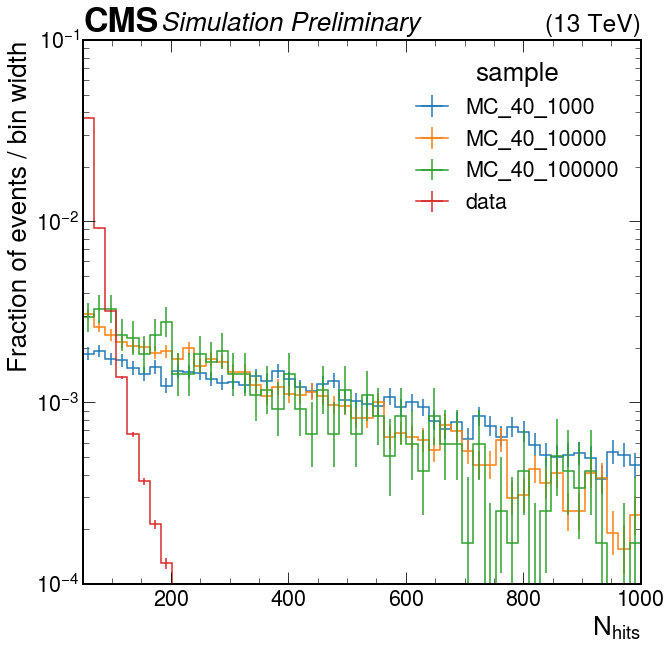

In [310]:
ax = hist.plot1d(h,density=True)
ax.set_ylabel("Fraction of events / bin width")
ax.set_yscale("log")
ax.set_ylim(1e-4,0.1)
hep.cms.label(ax=ax,label="Preliminary") 

# Q: What are the efficiencies for $N_{hits}>130$ ?


In [313]:
for i, sample in enumerate(tree.keys()):
    # Fill code here
    eff = integral(h,sample,130)/integral(h,sample,None)
    print(r'sample = %s, eff($N_{hits}>130$) = %.5f '%(sample, eff))

sample = data, eff($N_{hits}>130$) = 0.03158 
sample = MC_40_1000, eff($N_{hits}>130$) = 0.88839 
sample = MC_40_10000, eff($N_{hits}>130$) = 0.82359 
sample = MC_40_100000, eff($N_{hits}>130$) = 0.79356 


/cvmfs/sft.cern.ch/lcg/views/LCG_105/x86_64-el9-gcc11-opt/lib/python3.9/site-packages/coffea/hist/hist_tools.py:631: RuntimeWarning: Reducing along axis <Bin (name=nhits) instance at 0x7ff45fd27070>: requested start 130 between bin boundaries, no interpolation is performed
  warnings.warn(


## plot abs($\Delta\phi\mathrm{(cluster, MET)}$)

In [314]:
nBins    = 50
bin_lo   = 0
bin_high = 3.2

h = hist.Hist("Events",
              hist.Cat("sample","sample"), 
              hist.Bin("dphi", r"$\Delta\phi(cls,MET)$", nBins, bin_lo, bin_high)
             )


for i, sample in enumerate(tree.keys()):
    
    #See if we are treating data
    isData = True if ("data" in sample) else False
    
    # build the selection arrays
    sel_clusters, sel_jet, sel_ev = select_events(tree[sample],isData)

    # Get Variables
    dphi     = abs(tree[sample].cscRechitClusterMet_dPhi)
    nhits    = tree[sample].cscRechitClusterSize
    clsTime  = tree[sample].cscRechitClusterTime
    jetVeto  = tree[sample].cscRechitClusterJetVetoPt
    muonVeto = tree[sample].cscRechitClusterMuonVetoPt 
    clsEta   = tree[sample].cscRechitClusterEta    

    
    # Only plot Out-of-Time(OOT) region
    if isData:
        sel_time = clsTime< -12.5
    else:
        sel_time = clsTime> -5        
        
    # Apply cluster selection
    dphi = dphi[(sel_clusters) & (sel_time) & (jetVeto<10) & (muonVeto<20) & (clsEta<2)& (sel_ev)]
    
    # Select the VetoPt of the largest cluster 
    # fill_none puts -1 for events without clusters that satisfy the cluster cuts
    dphi = ak.fill_none(ak.firsts(dphi,axis=1),-999 ) 
    
    h.fill(sample=sample,dphi=dphi)

(exptext: Custom Text(0.0, 1, 'CMS'),
 expsuffix: Custom Text(0.0, 1.005, 'Simulation Preliminary'))

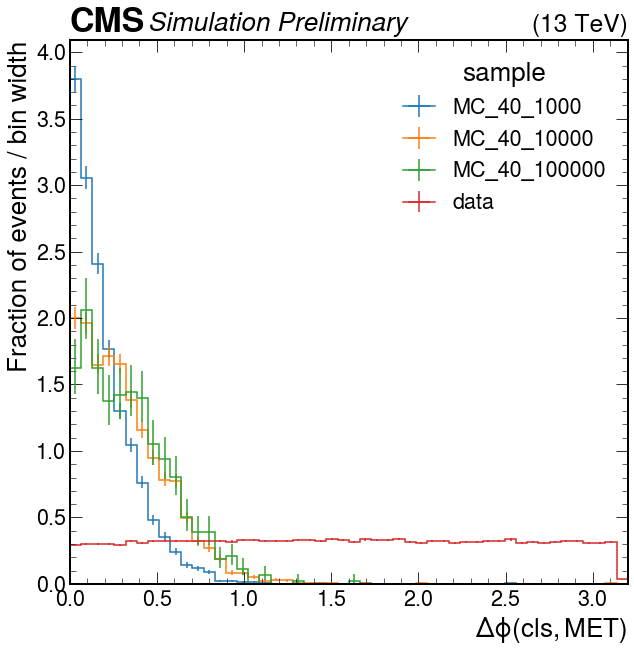

In [315]:
ax = hist.plot1d(h,density=True)
ax.set_ylabel("Fraction of events / bin width")
hep.cms.label(ax=ax,label="Preliminary") 

# Q: What are the efficiencies for $abs(\Delta\phi(cls,MET)<0.75)$ ?


In [316]:
for i, sample in enumerate(tree.keys()):
    # Fill code here
    eff = integral_low(h,sample,0.75)/integral(h,sample,None)
    print(r'sample = %s, eff($abs(\Delta\phi(cls,MET)<0.75)$) = %.5f '%(sample, eff))

sample = data, eff($abs(\Delta\phi(cls,MET)<0.75)$) = 0.23750 
sample = MC_40_1000, eff($abs(\Delta\phi(cls,MET)<0.75)$) = 0.98934 
sample = MC_40_10000, eff($abs(\Delta\phi(cls,MET)<0.75)$) = 0.95019 
sample = MC_40_100000, eff($abs(\Delta\phi(cls,MET)<0.75)$) = 0.93558 


/cvmfs/sft.cern.ch/lcg/views/LCG_105/x86_64-el9-gcc11-opt/lib/python3.9/site-packages/coffea/hist/hist_tools.py:658: RuntimeWarning: Reducing along axis <Bin (name=dphi) instance at 0x7ff45faa8340>: requested stop 0.75 between bin boundaries, no interpolation is performed
  warnings.warn(
